In [1]:
# If you don't already have it...
#import sys
#!{sys.executable} -m pip install nflows

### Setting up the flow
Here we define a 2D Gaussian, and a flow I guess starts from the base distribution and then applies the transforms
What we need is to give it something to flow towards...

In [2]:
from nflows import transforms, distributions, flows
import torch
import matplotlib.pyplot as plt


# Define an invertible transformation.
# Need to learn what these transforms do/why we might want to use these.
transform = transforms.CompositeTransform([
    transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=4),
    transforms.RandomPermutation(features=2)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[2])
print(base_distribution)

# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)
print(flow)


StandardNormal()
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=4, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=4, out_features=4, bias=True)
        )
      )
      (1): RandomPermutation()
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)


Plotting of the base distribution/sampling from it

tensor([[ 2.1713,  4.7098],
        [ 0.9985, -2.5461],
        [ 0.7444, -1.0861],
        ...,
        [ 0.0525,  1.9747],
        [ 1.1391, -1.0803],
        [ 1.0827,  1.7317]])
<class 'torch.Tensor'>
torch.Size([1000, 2])
tensor([2.1713, 4.7098])


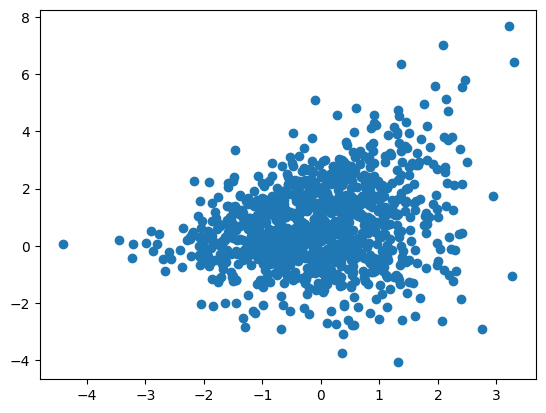

In [3]:
torch.manual_seed(42)
with torch.inference_mode():
    num_samples = 1000
    samples = flow.sample(num_samples)
    print(samples)
    print(type(samples))
    print(samples.shape)
    print(samples[:][0])

    # Gotta plot them 
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.show()

Let's try to get it to just flow to another 2D Gaussian in a different spot

In [4]:
n_target = 1000
# Generate some target data.
# Shift and scale it to make it different from the base distribution.
torch.manual_seed(7)
target = 2.0 * torch.randn(n_target, 2) + 5
print(target.shape)
print(target)


torch.Size([1000, 2])
tensor([[ 3.3597,  5.7913],
        [ 6.7978,  2.2232],
        [ 4.6660,  5.5703],
        ...,
        [-0.0277,  3.7431],
        [ 5.1095,  7.2784],
        [ 6.7261,  4.8058]])


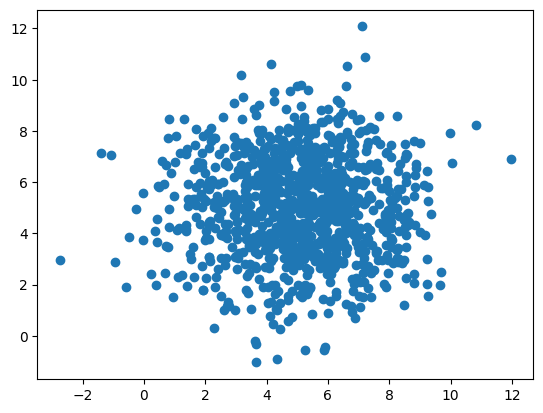

In [5]:
# Show the target distribution
with torch.inference_mode():
    plt.scatter(target[:, 0], target[:, 1])
    plt.show()

OK, now we have a target to hit, we should try to train the flow to go from base to target...

This means we'll need to now define a training and testing loop

Loss at iteration 0: 15.513494491577148


/home/epp/phrrkw/.local/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


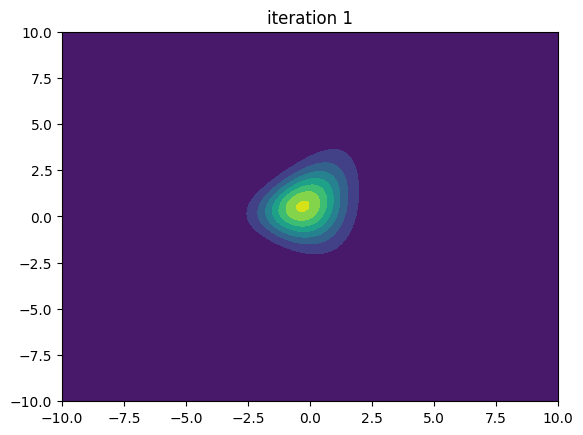

Loss at iteration 1000: 5.878666400909424


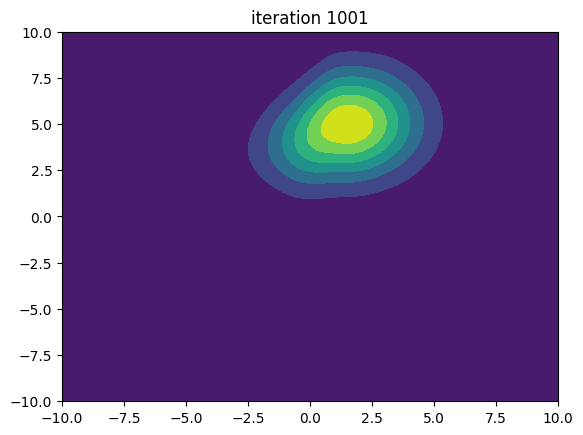

Loss at iteration 2000: 4.505063056945801


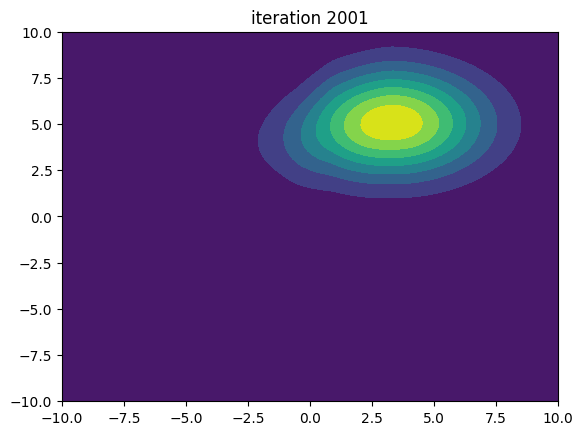

Loss at iteration 3000: 4.3282012939453125


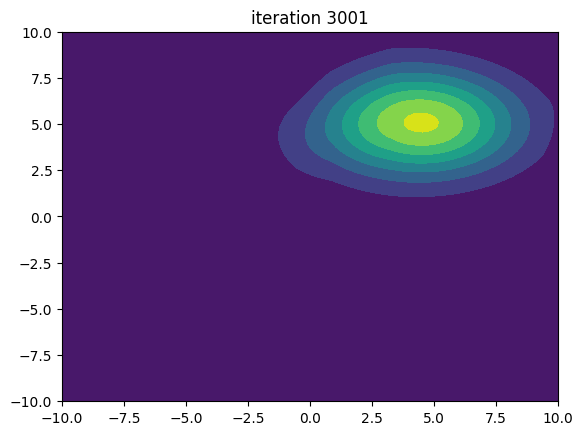

Loss at iteration 4000: 4.287166118621826


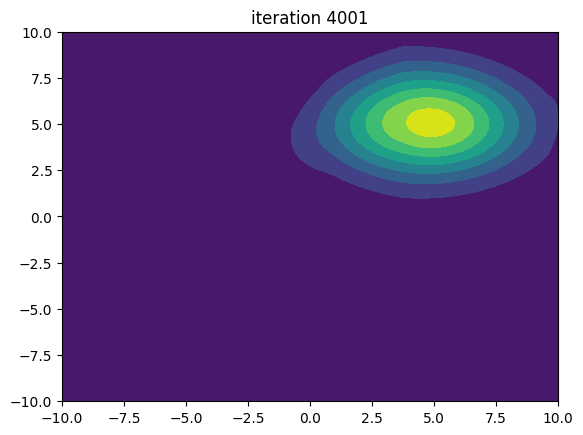

In [6]:
from torch import optim, nn
optimizer = optim.Adam(flow.parameters())
n_iter = 5000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    # TODO Need to understand why we zero_grad() before calculating the loss.
    # TODO also need to undestand the loss
    # TODO why no forward pass? 
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=target).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % 1000 == 0:
            print(f"Loss at iteration {i}: {loss}")
            xline = torch.linspace(-10, 10, 100)
            yline = torch.linspace(-10, 10, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.title('iteration {}'.format(i + 1))
            plt.show()




The above seems to work quite nicely! It'll train reasonably quickly, and you see the loss go down and the greater probabilities move towards the top-right corner as it should do.

A visualisation improvement might be to overlay the target sample.

### Next steps
* Just do a 1D flow from normal -> another weird normal,
* Instead of sampled "weird normal", get some Z IP data and flow to that,
* Histogram the datasets and calculate a chi2 metric to evaluate the success
* Look at how the loss is evolving with more iterations - try to set a tolerance for when it is good enough.
* Make the code device agnostic/start using the GPU on the machine.
* Flow *from* the uncorrected LHCb simulation -> the Z IP data.
